In [2]:
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from collections import *
from PIL import Image

In [3]:
style = Image.open('resource/image2.jpg')
content = Image.open('resource/image1.jpg')

trfms = [
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
]

for f in trfms:
    content = f(content)
    style = f(style)

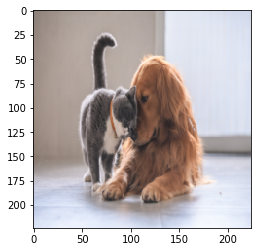

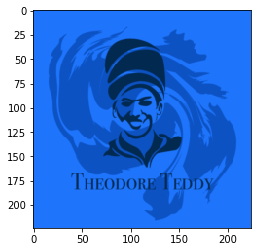

In [4]:
content = transforms.ToTensor()(transforms.ToPILImage()(content).convert("RGB"))
style = transforms.ToTensor()(transforms.ToPILImage()(style).convert("RGB"))
plt.imshow(transforms.ToPILImage()(content))
plt.show()
plt.imshow(transforms.ToPILImage()(style))
plt.show()

In [5]:
content = content.view(1, 3, 224, 224)
style = style.view(1, 3, 224, 224)

cnn = torchvision.models.vgg19(pretrained=True).features

In [17]:
class ContentLoss(torch.nn.Module):
    
    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.criterion = torch.nn.MSELoss()

    def forward(self, image):
        self.loss = self.criterion.forward(image * self.weight, self.target)
        self.output = image
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss


class GramMatrix(torch.nn.Module):
    
    def forward(self, image):
        a, b, c, d = image.size()
        features = image.view(a * b, c * d)
        G = torch.mm(features, features.t())
        return G.div(a * b * c * d)


class StyleLoss(torch.nn.Module):
    
    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = torch.nn.MSELoss()

    def forward(self, image):
        self.output = image.clone()
        self.G = self.gram.forward(image)
        self.G.mul_(self.weight)
        self.loss = self.criterion.forward(self.G, self.target)
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss
    

class TransferNet:
    
    CONTENT_LAYERS = ['conv_4']
    STYLE_LAYERS = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
        
    def __init__(self, content, style, model, content_weight, style_weight):
        
        self.image = content.clone()
        self.content = content
        self.style = style
        self.model = torch.nn.Sequential()
        self.style_losses = []
        self.content_losses = []
        self.gram = GramMatrix()

        i = 1
        for layer in list(model):
            if isinstance(layer, torch.nn.Conv2d):
                name = "conv_" + str(i)
                self.model.add_module(name, layer)

                if name in self.CONTENT_LAYERS:
                    target = self.model.forward(self.content).clone()
                    content_loss = ContentLoss(target, content_weight)
                    self.model.add_module("content_loss_" + str(i), content_loss)
                    self.content_losses.append(content_loss)

                if name in self.STYLE_LAYERS:
                    target_feature = self.model.forward(self.style).clone()
                    target_feature_gram = self.gram.forward(target_feature)
                    style_loss = StyleLoss(target_feature_gram, style_weight)
                    self.model.add_module("style_loss_" + str(i), style_loss)
                    self.style_losses.append(style_loss)

            if isinstance(layer, torch.nn.ReLU):
                name = "relu_" + str(i)
                self.model.add_module(name, layer)

                if name in self.CONTENT_LAYERS:
                    target = self.model.forward(self.content).clone()
                    content_loss = ContentLoss(target, content_weight)
                    self.model.add_module("content_loss_" + str(i), content_loss)
                    self.content_losses.append(content_loss)

                if name in self.STYLE_LAYERS:
                    target_feature = self.model.forward(self.style).clone()
                    target_feature_gram = self.gram.forward(target_feature)
                    style_loss = StyleLoss(target_feature_gram, style_weight)
                    self.model.add_module("style_loss_" + str(i), style_loss)
                    self.style_losses.append(style_loss)

                i += 1

            if isinstance(layer, torch.nn.MaxPool2d):
                name = "pool_" + str(i)
                self.model.add_module(name, layer)
                        
        
    def forward(self, epoches):
        
        image = torch.nn.Parameter(self.image.data)
        optimizer = torch.optim.Adam([image], lr=0.03)
        
        for epoch in range(epoches):
        
            def closure():
                image.data.clamp_(0, 1)

                optimizer.zero_grad()
                self.model.forward(image)

                style_score = 0
                content_score = 0

                for sl in self.style_losses:
                    style_score += sl.backward()

                for cl in self.content_losses:
                    content_score += cl.backward()
                    
                loss = content_score + style_score
                print(loss)
                return loss

            optimizer.step(closure)
            
            if epoch != 0 and epoch % 20 == 0:
                plt.imshow(transforms.ToPILImage()(image.squeeze()))
                plt.show()

In [18]:
net = TransferNet(content, style, cnn, 1, 1000)

tensor(3.2842, grad_fn=<AddBackward0>)
tensor(51.5859, grad_fn=<AddBackward0>)
tensor(22.0114, grad_fn=<AddBackward0>)
tensor(37.9001, grad_fn=<AddBackward0>)
tensor(27.7679, grad_fn=<AddBackward0>)
tensor(21.9281, grad_fn=<AddBackward0>)
tensor(19.4856, grad_fn=<AddBackward0>)
tensor(17.4837, grad_fn=<AddBackward0>)
tensor(15.6651, grad_fn=<AddBackward0>)
tensor(14.0091, grad_fn=<AddBackward0>)
tensor(12.3811, grad_fn=<AddBackward0>)
tensor(11.0159, grad_fn=<AddBackward0>)
tensor(10.0684, grad_fn=<AddBackward0>)
tensor(9.3454, grad_fn=<AddBackward0>)
tensor(8.6248, grad_fn=<AddBackward0>)
tensor(7.9400, grad_fn=<AddBackward0>)
tensor(7.3506, grad_fn=<AddBackward0>)
tensor(6.8359, grad_fn=<AddBackward0>)
tensor(6.3756, grad_fn=<AddBackward0>)
tensor(5.9618, grad_fn=<AddBackward0>)
tensor(5.5905, grad_fn=<AddBackward0>)


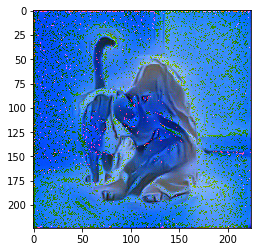

tensor(5.2592, grad_fn=<AddBackward0>)
tensor(4.9597, grad_fn=<AddBackward0>)
tensor(4.6990, grad_fn=<AddBackward0>)
tensor(4.4686, grad_fn=<AddBackward0>)
tensor(4.2500, grad_fn=<AddBackward0>)
tensor(4.0501, grad_fn=<AddBackward0>)
tensor(3.8779, grad_fn=<AddBackward0>)
tensor(3.7326, grad_fn=<AddBackward0>)
tensor(3.6035, grad_fn=<AddBackward0>)
tensor(3.4886, grad_fn=<AddBackward0>)
tensor(3.3865, grad_fn=<AddBackward0>)
tensor(3.2932, grad_fn=<AddBackward0>)
tensor(3.2070, grad_fn=<AddBackward0>)
tensor(3.1302, grad_fn=<AddBackward0>)
tensor(3.0604, grad_fn=<AddBackward0>)
tensor(2.9945, grad_fn=<AddBackward0>)
tensor(2.9339, grad_fn=<AddBackward0>)
tensor(2.8785, grad_fn=<AddBackward0>)
tensor(2.8270, grad_fn=<AddBackward0>)
tensor(2.7793, grad_fn=<AddBackward0>)


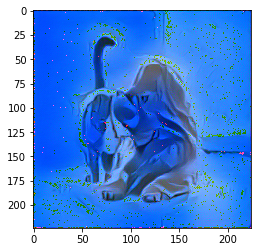

tensor(2.7350, grad_fn=<AddBackward0>)
tensor(2.6934, grad_fn=<AddBackward0>)
tensor(2.6545, grad_fn=<AddBackward0>)
tensor(2.6182, grad_fn=<AddBackward0>)
tensor(2.5838, grad_fn=<AddBackward0>)
tensor(2.5514, grad_fn=<AddBackward0>)
tensor(2.5210, grad_fn=<AddBackward0>)
tensor(2.4923, grad_fn=<AddBackward0>)
tensor(2.4650, grad_fn=<AddBackward0>)
tensor(2.4389, grad_fn=<AddBackward0>)
tensor(2.4144, grad_fn=<AddBackward0>)
tensor(2.3910, grad_fn=<AddBackward0>)
tensor(2.3688, grad_fn=<AddBackward0>)
tensor(2.3477, grad_fn=<AddBackward0>)
tensor(2.3276, grad_fn=<AddBackward0>)
tensor(2.3084, grad_fn=<AddBackward0>)
tensor(2.2901, grad_fn=<AddBackward0>)
tensor(2.2726, grad_fn=<AddBackward0>)
tensor(2.2558, grad_fn=<AddBackward0>)
tensor(2.2399, grad_fn=<AddBackward0>)


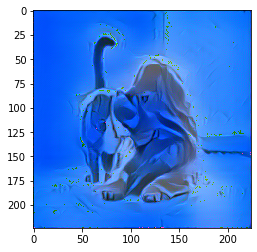

tensor(2.2247, grad_fn=<AddBackward0>)
tensor(2.2101, grad_fn=<AddBackward0>)
tensor(2.1962, grad_fn=<AddBackward0>)
tensor(2.1828, grad_fn=<AddBackward0>)
tensor(2.1699, grad_fn=<AddBackward0>)
tensor(2.1574, grad_fn=<AddBackward0>)
tensor(2.1455, grad_fn=<AddBackward0>)
tensor(2.1339, grad_fn=<AddBackward0>)
tensor(2.1227, grad_fn=<AddBackward0>)
tensor(2.1120, grad_fn=<AddBackward0>)
tensor(2.1016, grad_fn=<AddBackward0>)
tensor(2.0915, grad_fn=<AddBackward0>)
tensor(2.0817, grad_fn=<AddBackward0>)
tensor(2.0722, grad_fn=<AddBackward0>)
tensor(2.0630, grad_fn=<AddBackward0>)
tensor(2.0542, grad_fn=<AddBackward0>)
tensor(2.0456, grad_fn=<AddBackward0>)
tensor(2.0373, grad_fn=<AddBackward0>)
tensor(2.0292, grad_fn=<AddBackward0>)
tensor(2.0213, grad_fn=<AddBackward0>)


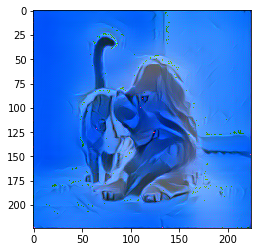

tensor(2.0136, grad_fn=<AddBackward0>)
tensor(2.0062, grad_fn=<AddBackward0>)
tensor(1.9989, grad_fn=<AddBackward0>)
tensor(1.9919, grad_fn=<AddBackward0>)
tensor(1.9849, grad_fn=<AddBackward0>)
tensor(1.9782, grad_fn=<AddBackward0>)
tensor(1.9715, grad_fn=<AddBackward0>)
tensor(1.9651, grad_fn=<AddBackward0>)
tensor(1.9588, grad_fn=<AddBackward0>)
tensor(1.9526, grad_fn=<AddBackward0>)
tensor(1.9466, grad_fn=<AddBackward0>)
tensor(1.9406, grad_fn=<AddBackward0>)
tensor(1.9349, grad_fn=<AddBackward0>)
tensor(1.9292, grad_fn=<AddBackward0>)
tensor(1.9236, grad_fn=<AddBackward0>)
tensor(1.9181, grad_fn=<AddBackward0>)
tensor(1.9127, grad_fn=<AddBackward0>)
tensor(1.9074, grad_fn=<AddBackward0>)
tensor(1.9022, grad_fn=<AddBackward0>)
tensor(1.8971, grad_fn=<AddBackward0>)


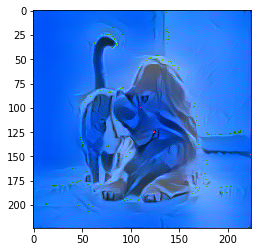

tensor(1.8921, grad_fn=<AddBackward0>)
tensor(1.8872, grad_fn=<AddBackward0>)
tensor(1.8823, grad_fn=<AddBackward0>)
tensor(1.8776, grad_fn=<AddBackward0>)
tensor(1.8728, grad_fn=<AddBackward0>)
tensor(1.8682, grad_fn=<AddBackward0>)
tensor(1.8637, grad_fn=<AddBackward0>)
tensor(1.8592, grad_fn=<AddBackward0>)
tensor(1.8547, grad_fn=<AddBackward0>)
tensor(1.8504, grad_fn=<AddBackward0>)
tensor(1.8461, grad_fn=<AddBackward0>)
tensor(1.8419, grad_fn=<AddBackward0>)
tensor(1.8379, grad_fn=<AddBackward0>)
tensor(1.8341, grad_fn=<AddBackward0>)
tensor(1.8309, grad_fn=<AddBackward0>)
tensor(1.8292, grad_fn=<AddBackward0>)
tensor(1.8302, grad_fn=<AddBackward0>)
tensor(1.8379, grad_fn=<AddBackward0>)
tensor(1.8550, grad_fn=<AddBackward0>)
tensor(1.8904, grad_fn=<AddBackward0>)


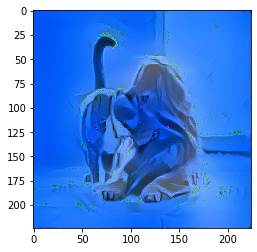

tensor(1.9262, grad_fn=<AddBackward0>)
tensor(1.9651, grad_fn=<AddBackward0>)
tensor(1.9346, grad_fn=<AddBackward0>)
tensor(1.8796, grad_fn=<AddBackward0>)
tensor(1.8187, grad_fn=<AddBackward0>)
tensor(1.8180, grad_fn=<AddBackward0>)
tensor(1.8525, grad_fn=<AddBackward0>)
tensor(1.8622, grad_fn=<AddBackward0>)
tensor(1.8416, grad_fn=<AddBackward0>)
tensor(1.8056, grad_fn=<AddBackward0>)
tensor(1.7953, grad_fn=<AddBackward0>)
tensor(1.8076, grad_fn=<AddBackward0>)
tensor(1.8142, grad_fn=<AddBackward0>)
tensor(1.8074, grad_fn=<AddBackward0>)
tensor(1.7873, grad_fn=<AddBackward0>)
tensor(1.7738, grad_fn=<AddBackward0>)
tensor(1.7715, grad_fn=<AddBackward0>)
tensor(1.7751, grad_fn=<AddBackward0>)
tensor(1.7782, grad_fn=<AddBackward0>)
tensor(1.7740, grad_fn=<AddBackward0>)


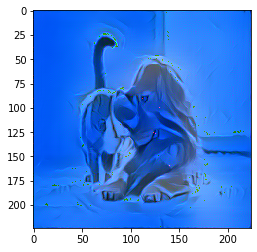

tensor(1.7664, grad_fn=<AddBackward0>)
tensor(1.7555, grad_fn=<AddBackward0>)
tensor(1.7470, grad_fn=<AddBackward0>)
tensor(1.7413, grad_fn=<AddBackward0>)
tensor(1.7386, grad_fn=<AddBackward0>)
tensor(1.7380, grad_fn=<AddBackward0>)
tensor(1.7383, grad_fn=<AddBackward0>)
tensor(1.7414, grad_fn=<AddBackward0>)
tensor(1.7461, grad_fn=<AddBackward0>)
tensor(1.7561, grad_fn=<AddBackward0>)
tensor(1.7662, grad_fn=<AddBackward0>)
tensor(1.7797, grad_fn=<AddBackward0>)
tensor(1.7790, grad_fn=<AddBackward0>)
tensor(1.7732, grad_fn=<AddBackward0>)
tensor(1.7458, grad_fn=<AddBackward0>)
tensor(1.7224, grad_fn=<AddBackward0>)
tensor(1.7087, grad_fn=<AddBackward0>)
tensor(1.7101, grad_fn=<AddBackward0>)
tensor(1.7204, grad_fn=<AddBackward0>)
tensor(1.7308, grad_fn=<AddBackward0>)


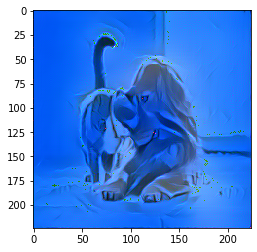

tensor(1.7415, grad_fn=<AddBackward0>)
tensor(1.7410, grad_fn=<AddBackward0>)
tensor(1.7363, grad_fn=<AddBackward0>)
tensor(1.7185, grad_fn=<AddBackward0>)
tensor(1.7027, grad_fn=<AddBackward0>)
tensor(1.6886, grad_fn=<AddBackward0>)
tensor(1.6831, grad_fn=<AddBackward0>)
tensor(1.6839, grad_fn=<AddBackward0>)
tensor(1.6885, grad_fn=<AddBackward0>)
tensor(1.6992, grad_fn=<AddBackward0>)
tensor(1.7157, grad_fn=<AddBackward0>)
tensor(1.7491, grad_fn=<AddBackward0>)
tensor(1.7827, grad_fn=<AddBackward0>)
tensor(1.8322, grad_fn=<AddBackward0>)
tensor(1.8204, grad_fn=<AddBackward0>)
tensor(1.7940, grad_fn=<AddBackward0>)
tensor(1.7174, grad_fn=<AddBackward0>)
tensor(1.6806, grad_fn=<AddBackward0>)
tensor(1.6848, grad_fn=<AddBackward0>)
tensor(1.7146, grad_fn=<AddBackward0>)


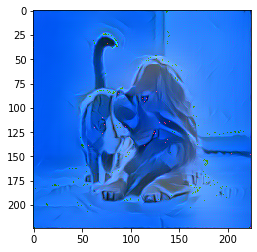

tensor(1.7586, grad_fn=<AddBackward0>)
tensor(1.7826, grad_fn=<AddBackward0>)
tensor(1.7962, grad_fn=<AddBackward0>)
tensor(1.7511, grad_fn=<AddBackward0>)
tensor(1.7071, grad_fn=<AddBackward0>)
tensor(1.6697, grad_fn=<AddBackward0>)
tensor(1.6680, grad_fn=<AddBackward0>)
tensor(1.6897, grad_fn=<AddBackward0>)
tensor(1.7164, grad_fn=<AddBackward0>)
tensor(1.7540, grad_fn=<AddBackward0>)
tensor(1.7645, grad_fn=<AddBackward0>)
tensor(1.7683, grad_fn=<AddBackward0>)
tensor(1.7222, grad_fn=<AddBackward0>)
tensor(1.6837, grad_fn=<AddBackward0>)
tensor(1.6514, grad_fn=<AddBackward0>)
tensor(1.6486, grad_fn=<AddBackward0>)
tensor(1.6653, grad_fn=<AddBackward0>)
tensor(1.6880, grad_fn=<AddBackward0>)
tensor(1.7259, grad_fn=<AddBackward0>)
tensor(1.7531, grad_fn=<AddBackward0>)


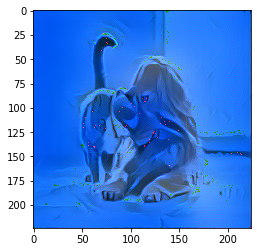

tensor(1.7861, grad_fn=<AddBackward0>)
tensor(1.7551, grad_fn=<AddBackward0>)
tensor(1.7212, grad_fn=<AddBackward0>)
tensor(1.6602, grad_fn=<AddBackward0>)
tensor(1.6377, grad_fn=<AddBackward0>)
tensor(1.6425, grad_fn=<AddBackward0>)
tensor(1.6655, grad_fn=<AddBackward0>)
tensor(1.7143, grad_fn=<AddBackward0>)
tensor(1.7745, grad_fn=<AddBackward0>)
tensor(1.8759, grad_fn=<AddBackward0>)
tensor(1.8824, grad_fn=<AddBackward0>)
tensor(1.8781, grad_fn=<AddBackward0>)
tensor(1.7337, grad_fn=<AddBackward0>)
tensor(1.6635, grad_fn=<AddBackward0>)
tensor(1.6526, grad_fn=<AddBackward0>)
tensor(1.6949, grad_fn=<AddBackward0>)
tensor(1.7942, grad_fn=<AddBackward0>)
tensor(1.9029, grad_fn=<AddBackward0>)
tensor(2.0808, grad_fn=<AddBackward0>)
tensor(1.9998, grad_fn=<AddBackward0>)


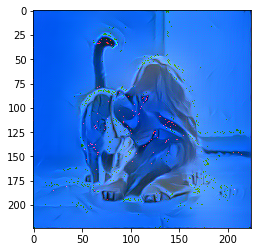

tensor(1.9415, grad_fn=<AddBackward0>)
tensor(1.7304, grad_fn=<AddBackward0>)
tensor(1.6888, grad_fn=<AddBackward0>)
tensor(1.7113, grad_fn=<AddBackward0>)
tensor(1.7761, grad_fn=<AddBackward0>)
tensor(2.0000, grad_fn=<AddBackward0>)
tensor(2.2870, grad_fn=<AddBackward0>)
tensor(2.8812, grad_fn=<AddBackward0>)
tensor(2.4092, grad_fn=<AddBackward0>)
tensor(2.5051, grad_fn=<AddBackward0>)
tensor(2.0702, grad_fn=<AddBackward0>)
tensor(2.1435, grad_fn=<AddBackward0>)
tensor(2.0495, grad_fn=<AddBackward0>)
tensor(2.2165, grad_fn=<AddBackward0>)
tensor(2.3600, grad_fn=<AddBackward0>)
tensor(3.2554, grad_fn=<AddBackward0>)
tensor(3.2166, grad_fn=<AddBackward0>)
tensor(4.2345, grad_fn=<AddBackward0>)
tensor(2.8446, grad_fn=<AddBackward0>)
tensor(3.3066, grad_fn=<AddBackward0>)


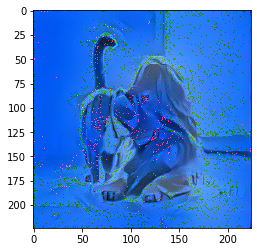

tensor(2.7451, grad_fn=<AddBackward0>)
tensor(3.1768, grad_fn=<AddBackward0>)
tensor(3.0354, grad_fn=<AddBackward0>)
tensor(4.0962, grad_fn=<AddBackward0>)
tensor(3.6362, grad_fn=<AddBackward0>)
tensor(4.8916, grad_fn=<AddBackward0>)
tensor(3.4069, grad_fn=<AddBackward0>)
tensor(4.0399, grad_fn=<AddBackward0>)
tensor(3.2234, grad_fn=<AddBackward0>)
tensor(3.4894, grad_fn=<AddBackward0>)
tensor(3.1062, grad_fn=<AddBackward0>)
tensor(3.4038, grad_fn=<AddBackward0>)
tensor(3.1475, grad_fn=<AddBackward0>)
tensor(3.7109, grad_fn=<AddBackward0>)
tensor(3.3142, grad_fn=<AddBackward0>)
tensor(3.7909, grad_fn=<AddBackward0>)
tensor(3.0064, grad_fn=<AddBackward0>)
tensor(3.0721, grad_fn=<AddBackward0>)
tensor(2.6700, grad_fn=<AddBackward0>)
tensor(2.6234, grad_fn=<AddBackward0>)


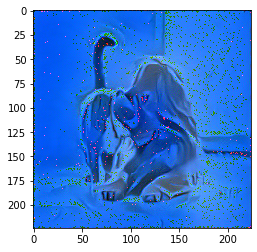

tensor(2.5314, grad_fn=<AddBackward0>)
tensor(2.4530, grad_fn=<AddBackward0>)
tensor(2.4877, grad_fn=<AddBackward0>)
tensor(2.4440, grad_fn=<AddBackward0>)
tensor(2.6804, grad_fn=<AddBackward0>)
tensor(2.6438, grad_fn=<AddBackward0>)
tensor(2.8592, grad_fn=<AddBackward0>)
tensor(2.4038, grad_fn=<AddBackward0>)
tensor(2.2524, grad_fn=<AddBackward0>)
tensor(2.1129, grad_fn=<AddBackward0>)
tensor(2.1391, grad_fn=<AddBackward0>)
tensor(2.2656, grad_fn=<AddBackward0>)
tensor(2.1810, grad_fn=<AddBackward0>)
tensor(2.1571, grad_fn=<AddBackward0>)
tensor(1.9933, grad_fn=<AddBackward0>)
tensor(1.9447, grad_fn=<AddBackward0>)
tensor(1.9476, grad_fn=<AddBackward0>)
tensor(1.9464, grad_fn=<AddBackward0>)
tensor(1.9809, grad_fn=<AddBackward0>)
tensor(1.9378, grad_fn=<AddBackward0>)


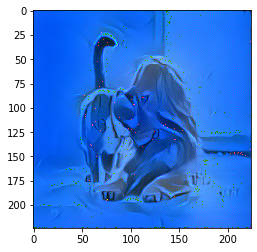

tensor(1.9104, grad_fn=<AddBackward0>)
tensor(1.8301, grad_fn=<AddBackward0>)
tensor(1.7952, grad_fn=<AddBackward0>)
tensor(1.7887, grad_fn=<AddBackward0>)
tensor(1.7875, grad_fn=<AddBackward0>)
tensor(1.7921, grad_fn=<AddBackward0>)
tensor(1.7644, grad_fn=<AddBackward0>)
tensor(1.7390, grad_fn=<AddBackward0>)
tensor(1.7055, grad_fn=<AddBackward0>)
tensor(1.6887, grad_fn=<AddBackward0>)
tensor(1.6830, grad_fn=<AddBackward0>)
tensor(1.6780, grad_fn=<AddBackward0>)
tensor(1.6743, grad_fn=<AddBackward0>)
tensor(1.6597, grad_fn=<AddBackward0>)
tensor(1.6448, grad_fn=<AddBackward0>)
tensor(1.6278, grad_fn=<AddBackward0>)
tensor(1.6172, grad_fn=<AddBackward0>)
tensor(1.6113, grad_fn=<AddBackward0>)
tensor(1.6068, grad_fn=<AddBackward0>)
tensor(1.6034, grad_fn=<AddBackward0>)


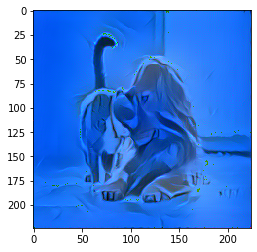

tensor(1.5965, grad_fn=<AddBackward0>)
tensor(1.5894, grad_fn=<AddBackward0>)
tensor(1.5798, grad_fn=<AddBackward0>)
tensor(1.5717, grad_fn=<AddBackward0>)
tensor(1.5644, grad_fn=<AddBackward0>)
tensor(1.5592, grad_fn=<AddBackward0>)
tensor(1.5555, grad_fn=<AddBackward0>)
tensor(1.5519, grad_fn=<AddBackward0>)
tensor(1.5486, grad_fn=<AddBackward0>)
tensor(1.5443, grad_fn=<AddBackward0>)
tensor(1.5399, grad_fn=<AddBackward0>)
tensor(1.5349, grad_fn=<AddBackward0>)
tensor(1.5304, grad_fn=<AddBackward0>)
tensor(1.5263, grad_fn=<AddBackward0>)
tensor(1.5229, grad_fn=<AddBackward0>)
tensor(1.5199, grad_fn=<AddBackward0>)
tensor(1.5172, grad_fn=<AddBackward0>)
tensor(1.5147, grad_fn=<AddBackward0>)
tensor(1.5121, grad_fn=<AddBackward0>)
tensor(1.5098, grad_fn=<AddBackward0>)


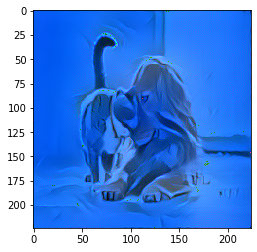

tensor(1.5073, grad_fn=<AddBackward0>)
tensor(1.5052, grad_fn=<AddBackward0>)
tensor(1.5028, grad_fn=<AddBackward0>)
tensor(1.5007, grad_fn=<AddBackward0>)
tensor(1.4982, grad_fn=<AddBackward0>)
tensor(1.4959, grad_fn=<AddBackward0>)
tensor(1.4935, grad_fn=<AddBackward0>)
tensor(1.4913, grad_fn=<AddBackward0>)
tensor(1.4891, grad_fn=<AddBackward0>)
tensor(1.4871, grad_fn=<AddBackward0>)
tensor(1.4852, grad_fn=<AddBackward0>)
tensor(1.4835, grad_fn=<AddBackward0>)
tensor(1.4819, grad_fn=<AddBackward0>)
tensor(1.4806, grad_fn=<AddBackward0>)
tensor(1.4794, grad_fn=<AddBackward0>)
tensor(1.4787, grad_fn=<AddBackward0>)
tensor(1.4781, grad_fn=<AddBackward0>)
tensor(1.4785, grad_fn=<AddBackward0>)
tensor(1.4791, grad_fn=<AddBackward0>)
tensor(1.4807, grad_fn=<AddBackward0>)


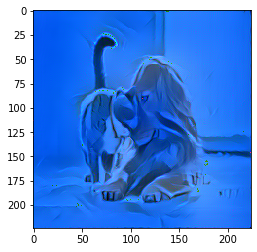

tensor(1.4816, grad_fn=<AddBackward0>)
tensor(1.4824, grad_fn=<AddBackward0>)
tensor(1.4803, grad_fn=<AddBackward0>)
tensor(1.4772, grad_fn=<AddBackward0>)
tensor(1.4720, grad_fn=<AddBackward0>)
tensor(1.4675, grad_fn=<AddBackward0>)
tensor(1.4636, grad_fn=<AddBackward0>)
tensor(1.4617, grad_fn=<AddBackward0>)
tensor(1.4611, grad_fn=<AddBackward0>)
tensor(1.4613, grad_fn=<AddBackward0>)
tensor(1.4625, grad_fn=<AddBackward0>)
tensor(1.4642, grad_fn=<AddBackward0>)
tensor(1.4678, grad_fn=<AddBackward0>)
tensor(1.4722, grad_fn=<AddBackward0>)
tensor(1.4796, grad_fn=<AddBackward0>)
tensor(1.4846, grad_fn=<AddBackward0>)
tensor(1.4886, grad_fn=<AddBackward0>)
tensor(1.4840, grad_fn=<AddBackward0>)
tensor(1.4766, grad_fn=<AddBackward0>)
tensor(1.4644, grad_fn=<AddBackward0>)


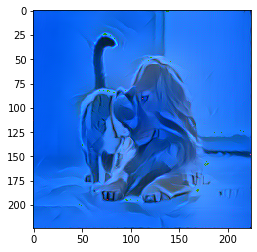

tensor(1.4559, grad_fn=<AddBackward0>)
tensor(1.4515, grad_fn=<AddBackward0>)
tensor(1.4520, grad_fn=<AddBackward0>)
tensor(1.4557, grad_fn=<AddBackward0>)
tensor(1.4603, grad_fn=<AddBackward0>)
tensor(1.4666, grad_fn=<AddBackward0>)
tensor(1.4705, grad_fn=<AddBackward0>)
tensor(1.4741, grad_fn=<AddBackward0>)
tensor(1.4704, grad_fn=<AddBackward0>)
tensor(1.4645, grad_fn=<AddBackward0>)
tensor(1.4541, grad_fn=<AddBackward0>)
tensor(1.4467, grad_fn=<AddBackward0>)
tensor(1.4425, grad_fn=<AddBackward0>)
tensor(1.4424, grad_fn=<AddBackward0>)
tensor(1.4448, grad_fn=<AddBackward0>)
tensor(1.4482, grad_fn=<AddBackward0>)
tensor(1.4538, grad_fn=<AddBackward0>)
tensor(1.4598, grad_fn=<AddBackward0>)
tensor(1.4694, grad_fn=<AddBackward0>)
tensor(1.4750, grad_fn=<AddBackward0>)


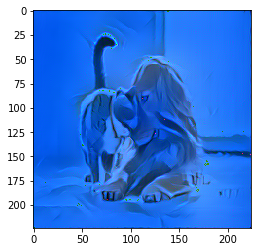

tensor(1.4816, grad_fn=<AddBackward0>)
tensor(1.4769, grad_fn=<AddBackward0>)
tensor(1.4700, grad_fn=<AddBackward0>)
tensor(1.4541, grad_fn=<AddBackward0>)
tensor(1.4424, grad_fn=<AddBackward0>)
tensor(1.4359, grad_fn=<AddBackward0>)
tensor(1.4364, grad_fn=<AddBackward0>)
tensor(1.4412, grad_fn=<AddBackward0>)
tensor(1.4469, grad_fn=<AddBackward0>)
tensor(1.4547, grad_fn=<AddBackward0>)
tensor(1.4612, grad_fn=<AddBackward0>)
tensor(1.4696, grad_fn=<AddBackward0>)
tensor(1.4709, grad_fn=<AddBackward0>)
tensor(1.4710, grad_fn=<AddBackward0>)
tensor(1.4596, grad_fn=<AddBackward0>)
tensor(1.4487, grad_fn=<AddBackward0>)
tensor(1.4361, grad_fn=<AddBackward0>)
tensor(1.4298, grad_fn=<AddBackward0>)
tensor(1.4285, grad_fn=<AddBackward0>)
tensor(1.4310, grad_fn=<AddBackward0>)


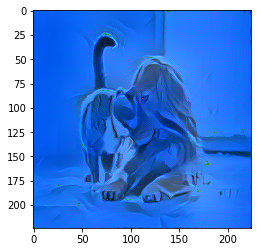

tensor(1.4369, grad_fn=<AddBackward0>)
tensor(1.4448, grad_fn=<AddBackward0>)
tensor(1.4597, grad_fn=<AddBackward0>)
tensor(1.4771, grad_fn=<AddBackward0>)
tensor(1.5038, grad_fn=<AddBackward0>)
tensor(1.5162, grad_fn=<AddBackward0>)
tensor(1.5284, grad_fn=<AddBackward0>)
tensor(1.5045, grad_fn=<AddBackward0>)
tensor(1.4824, grad_fn=<AddBackward0>)
tensor(1.4502, grad_fn=<AddBackward0>)
tensor(1.4353, grad_fn=<AddBackward0>)
tensor(1.4346, grad_fn=<AddBackward0>)
tensor(1.4441, grad_fn=<AddBackward0>)
tensor(1.4622, grad_fn=<AddBackward0>)
tensor(1.4823, grad_fn=<AddBackward0>)
tensor(1.5139, grad_fn=<AddBackward0>)
tensor(1.5332, grad_fn=<AddBackward0>)
tensor(1.5570, grad_fn=<AddBackward0>)
tensor(1.5326, grad_fn=<AddBackward0>)
tensor(1.5060, grad_fn=<AddBackward0>)


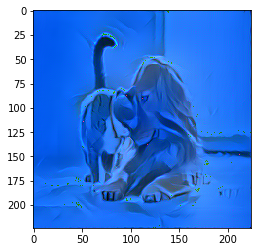

tensor(1.4590, grad_fn=<AddBackward0>)
tensor(1.4384, grad_fn=<AddBackward0>)
tensor(1.4392, grad_fn=<AddBackward0>)
tensor(1.4547, grad_fn=<AddBackward0>)
tensor(1.4848, grad_fn=<AddBackward0>)
tensor(1.5185, grad_fn=<AddBackward0>)
tensor(1.5778, grad_fn=<AddBackward0>)
tensor(1.6002, grad_fn=<AddBackward0>)
tensor(1.6198, grad_fn=<AddBackward0>)
tensor(1.5428, grad_fn=<AddBackward0>)
tensor(1.4838, grad_fn=<AddBackward0>)
tensor(1.4464, grad_fn=<AddBackward0>)
tensor(1.4575, grad_fn=<AddBackward0>)
tensor(1.4993, grad_fn=<AddBackward0>)
tensor(1.5502, grad_fn=<AddBackward0>)
tensor(1.6372, grad_fn=<AddBackward0>)
tensor(1.6662, grad_fn=<AddBackward0>)
tensor(1.6997, grad_fn=<AddBackward0>)
tensor(1.5940, grad_fn=<AddBackward0>)
tensor(1.5267, grad_fn=<AddBackward0>)


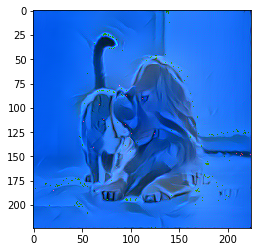

tensor(1.4691, grad_fn=<AddBackward0>)
tensor(1.4711, grad_fn=<AddBackward0>)
tensor(1.5044, grad_fn=<AddBackward0>)
tensor(1.5657, grad_fn=<AddBackward0>)
tensor(1.7292, grad_fn=<AddBackward0>)
tensor(1.9111, grad_fn=<AddBackward0>)
tensor(2.2230, grad_fn=<AddBackward0>)
tensor(2.0060, grad_fn=<AddBackward0>)
tensor(2.0671, grad_fn=<AddBackward0>)
tensor(1.7985, grad_fn=<AddBackward0>)
tensor(1.8339, grad_fn=<AddBackward0>)
tensor(1.7479, grad_fn=<AddBackward0>)
tensor(1.8539, grad_fn=<AddBackward0>)
tensor(1.9273, grad_fn=<AddBackward0>)
tensor(2.3991, grad_fn=<AddBackward0>)
tensor(2.5886, grad_fn=<AddBackward0>)
tensor(3.5636, grad_fn=<AddBackward0>)
tensor(2.8362, grad_fn=<AddBackward0>)
tensor(4.3869, grad_fn=<AddBackward0>)
tensor(4.1695, grad_fn=<AddBackward0>)


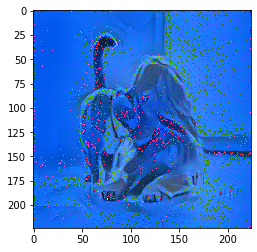

tensor(9.3522, grad_fn=<AddBackward0>)
tensor(8.1579, grad_fn=<AddBackward0>)
tensor(18.8042, grad_fn=<AddBackward0>)
tensor(20.3844, grad_fn=<AddBackward0>)
tensor(32.6936, grad_fn=<AddBackward0>)
tensor(31.6185, grad_fn=<AddBackward0>)
tensor(38.9145, grad_fn=<AddBackward0>)
tensor(35.9697, grad_fn=<AddBackward0>)
tensor(39.8874, grad_fn=<AddBackward0>)
tensor(35.2267, grad_fn=<AddBackward0>)
tensor(36.6906, grad_fn=<AddBackward0>)
tensor(31.9167, grad_fn=<AddBackward0>)
tensor(31.1353, grad_fn=<AddBackward0>)
tensor(27.0985, grad_fn=<AddBackward0>)
tensor(26.4091, grad_fn=<AddBackward0>)
tensor(22.9919, grad_fn=<AddBackward0>)
tensor(21.6522, grad_fn=<AddBackward0>)
tensor(18.9821, grad_fn=<AddBackward0>)
tensor(17.8751, grad_fn=<AddBackward0>)
tensor(15.4853, grad_fn=<AddBackward0>)


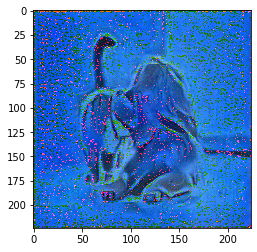

tensor(14.8329, grad_fn=<AddBackward0>)
tensor(12.8179, grad_fn=<AddBackward0>)
tensor(12.3383, grad_fn=<AddBackward0>)
tensor(10.7259, grad_fn=<AddBackward0>)
tensor(10.0989, grad_fn=<AddBackward0>)
tensor(8.8395, grad_fn=<AddBackward0>)
tensor(8.4303, grad_fn=<AddBackward0>)
tensor(7.4162, grad_fn=<AddBackward0>)
tensor(6.8812, grad_fn=<AddBackward0>)
tensor(6.2470, grad_fn=<AddBackward0>)
tensor(5.7794, grad_fn=<AddBackward0>)
tensor(5.3165, grad_fn=<AddBackward0>)
tensor(4.9546, grad_fn=<AddBackward0>)
tensor(4.6119, grad_fn=<AddBackward0>)
tensor(4.2975, grad_fn=<AddBackward0>)
tensor(4.0523, grad_fn=<AddBackward0>)
tensor(3.7999, grad_fn=<AddBackward0>)
tensor(3.5995, grad_fn=<AddBackward0>)
tensor(3.4231, grad_fn=<AddBackward0>)
tensor(3.2558, grad_fn=<AddBackward0>)


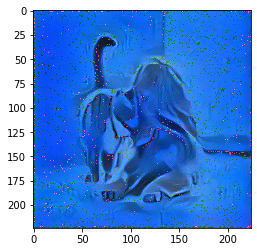

tensor(3.0965, grad_fn=<AddBackward0>)
tensor(2.9757, grad_fn=<AddBackward0>)
tensor(2.8564, grad_fn=<AddBackward0>)
tensor(2.7482, grad_fn=<AddBackward0>)
tensor(2.6514, grad_fn=<AddBackward0>)
tensor(2.5665, grad_fn=<AddBackward0>)
tensor(2.4913, grad_fn=<AddBackward0>)
tensor(2.4170, grad_fn=<AddBackward0>)
tensor(2.3532, grad_fn=<AddBackward0>)
tensor(2.2933, grad_fn=<AddBackward0>)
tensor(2.2404, grad_fn=<AddBackward0>)
tensor(2.1900, grad_fn=<AddBackward0>)
tensor(2.1446, grad_fn=<AddBackward0>)
tensor(2.1031, grad_fn=<AddBackward0>)
tensor(2.0655, grad_fn=<AddBackward0>)
tensor(2.0313, grad_fn=<AddBackward0>)
tensor(1.9992, grad_fn=<AddBackward0>)
tensor(1.9697, grad_fn=<AddBackward0>)
tensor(1.9416, grad_fn=<AddBackward0>)
tensor(1.9151, grad_fn=<AddBackward0>)


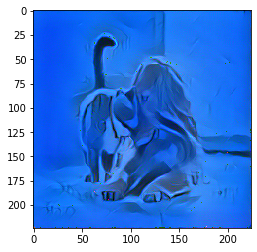

tensor(1.8900, grad_fn=<AddBackward0>)
tensor(1.8664, grad_fn=<AddBackward0>)
tensor(1.8444, grad_fn=<AddBackward0>)
tensor(1.8238, grad_fn=<AddBackward0>)
tensor(1.8046, grad_fn=<AddBackward0>)
tensor(1.7864, grad_fn=<AddBackward0>)
tensor(1.7696, grad_fn=<AddBackward0>)
tensor(1.7539, grad_fn=<AddBackward0>)
tensor(1.7391, grad_fn=<AddBackward0>)
tensor(1.7252, grad_fn=<AddBackward0>)
tensor(1.7120, grad_fn=<AddBackward0>)
tensor(1.6996, grad_fn=<AddBackward0>)
tensor(1.6879, grad_fn=<AddBackward0>)
tensor(1.6769, grad_fn=<AddBackward0>)
tensor(1.6665, grad_fn=<AddBackward0>)
tensor(1.6566, grad_fn=<AddBackward0>)
tensor(1.6471, grad_fn=<AddBackward0>)
tensor(1.6382, grad_fn=<AddBackward0>)
tensor(1.6297, grad_fn=<AddBackward0>)
tensor(1.6216, grad_fn=<AddBackward0>)


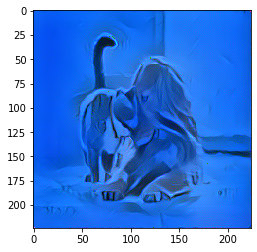

tensor(1.6139, grad_fn=<AddBackward0>)
tensor(1.6066, grad_fn=<AddBackward0>)
tensor(1.5996, grad_fn=<AddBackward0>)
tensor(1.5930, grad_fn=<AddBackward0>)
tensor(1.5866, grad_fn=<AddBackward0>)
tensor(1.5806, grad_fn=<AddBackward0>)
tensor(1.5749, grad_fn=<AddBackward0>)
tensor(1.5694, grad_fn=<AddBackward0>)
tensor(1.5641, grad_fn=<AddBackward0>)
tensor(1.5591, grad_fn=<AddBackward0>)
tensor(1.5542, grad_fn=<AddBackward0>)
tensor(1.5496, grad_fn=<AddBackward0>)
tensor(1.5452, grad_fn=<AddBackward0>)
tensor(1.5409, grad_fn=<AddBackward0>)
tensor(1.5368, grad_fn=<AddBackward0>)
tensor(1.5328, grad_fn=<AddBackward0>)
tensor(1.5291, grad_fn=<AddBackward0>)
tensor(1.5254, grad_fn=<AddBackward0>)
tensor(1.5219, grad_fn=<AddBackward0>)
tensor(1.5185, grad_fn=<AddBackward0>)


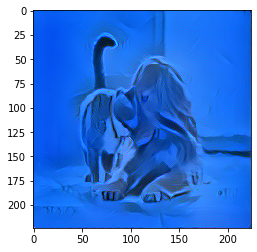

tensor(1.5152, grad_fn=<AddBackward0>)
tensor(1.5121, grad_fn=<AddBackward0>)
tensor(1.5090, grad_fn=<AddBackward0>)
tensor(1.5061, grad_fn=<AddBackward0>)
tensor(1.5032, grad_fn=<AddBackward0>)
tensor(1.5004, grad_fn=<AddBackward0>)
tensor(1.4977, grad_fn=<AddBackward0>)
tensor(1.4951, grad_fn=<AddBackward0>)
tensor(1.4926, grad_fn=<AddBackward0>)
tensor(1.4901, grad_fn=<AddBackward0>)
tensor(1.4877, grad_fn=<AddBackward0>)
tensor(1.4854, grad_fn=<AddBackward0>)
tensor(1.4831, grad_fn=<AddBackward0>)
tensor(1.4809, grad_fn=<AddBackward0>)
tensor(1.4788, grad_fn=<AddBackward0>)
tensor(1.4767, grad_fn=<AddBackward0>)
tensor(1.4747, grad_fn=<AddBackward0>)
tensor(1.4727, grad_fn=<AddBackward0>)
tensor(1.4708, grad_fn=<AddBackward0>)
tensor(1.4689, grad_fn=<AddBackward0>)


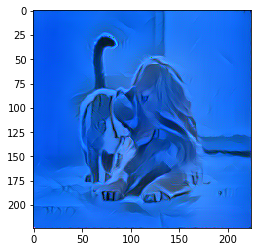

tensor(1.4671, grad_fn=<AddBackward0>)
tensor(1.4653, grad_fn=<AddBackward0>)
tensor(1.4636, grad_fn=<AddBackward0>)
tensor(1.4619, grad_fn=<AddBackward0>)
tensor(1.4603, grad_fn=<AddBackward0>)


In [ ]:
net.forward(1000)

In [ ]:
plt.imshow(transforms.ToPILImage()(net.image.squeeze()))
plt.show()